# A notebook to celebrate the 1 year of the tensoptly project!

The tensoptly project is funded by [Inria](https://www.inria.fr/en) AI project for the period 2021-2022. Its goal is to enhance the Tensorly toolbox with better algorithms in terms of
- Tensor decomposition models
- Convergence speed
- Flexibility (loss, constraints)
- Benchmarking
- User interface

The ultimate goal is to have better open-source and collaborative tools to work on tensors as researchers and data scientists.

I am truly blessed to be able to carry out this project with [Caglayan Tuna](https://github.com/caglayantuna), who has done an amazing job during this first year, as well as [Jean Kossaifi](http://jeankossaifi.com/) who is an incredible researcher and developper! We have already done a fair amount of contributions in the first three bullet points, which are detailled below. More will come this year regarding benchmarking, stay tuned!

In [1]:
# Using numpy backend for simplicity, but works with any backends supported in tensorly
import numpy as np
# Importing tensorly (version 0.7.0)
import tensorly as tl
from tensorly.decomposition import non_negative_parafac, non_negative_parafac_hals, non_negative_tucker, non_negative_tucker_hals
# scipy for importing
import scipy.io as spio
# matplotlib for plots
import matplotlib.pyplot as plt
# time for measuring runtime
import time
# copy for duplicating init tensors
from copy import deepcopy

## 1. Faster algorithms for nonnegative decompositions

Tensorly version<0.6 was using Multiplicative Updates to compute nonnegative Parafac/CP decomposition with the Frobenius loss. In the NMF literature, it is well known that MU is very flexible but not quite as efficient as other alternating methods such as Hierarchical Alternating Least Squares. Using a base code from [Axel Marmoret](https://ax-le.github.io/), we brought HALS in Tensorly!

Let's try these new functionalities on a toy fluorescence spectroscopy dataset from Rasmus Bro available [here](http://www.models.life.ku.dk/Amino_Acid_fluo) as a matlab file. It contains the fluorescence measurements from three fluorophores, in 5 different relative concentrations, on grids of emmision and excitation wavelengths.

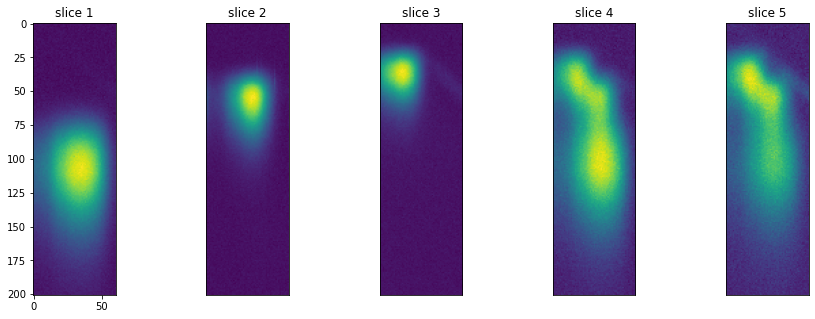

In [2]:
data = spio.loadmat('data.mat', squeeze_me=True)  # Data tensor extracted from amino in matlab
X = data['data']  # X is the tensor data, of size 5 by 201 by 61.
# Adding some noise for difficulty
X_noisy = X + 10*np.random.randn(5,201,61)
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_noisy[i,:,:])
    plt.title('slice '+str(i+1))
    if i>0:
        plt.xticks([])
        plt.yticks([])

We know from the literature that this dataset is almost exactly fitted by a rank-3 nonnegative CP decomposition. It is considered a toy dataset because it has almost no noise, no missing values, and running nonnegative CP almsot always yields perfect results. Let us see how MU and HALS algorithms compare here when fitting nonnegative CP and nonnegative Tucker.

In [3]:
# Providing an arbitrary user-defined initialization (new feature in tensorly v>=0.6)
init_tensor = (tl.ones(3),[np.random.rand(5,3),np.random.rand(201,3),np.random.rand(61,3)])

# Fitting a rank-3 nonnegative CP with MU
tic = time.time()
cptens_mu, err_cp_mu = non_negative_parafac(X_noisy,3,init=deepcopy(init_tensor),return_errors=True)
# note: tensorly new version will have dedicated .copy() in the next release
toc_mu = time.time()-tic
iter_time_mu = np.linspace(1/len(err_cp_mu),1,len(err_cp_mu))*toc_mu

# Fitting a rank-3 nonnegative CP with HALS
tic = time.time()
cptens_hals, err_cp_hals = non_negative_parafac_hals(X_noisy,3,init=deepcopy(init_tensor),return_errors=True, exact=False)
toc_hals = time.time()-tic
iter_time_hals = np.linspace(1/len(err_cp_hals),1,len(err_cp_hals))*toc_hals

In [4]:
# Adding a core to the initialization for Tucker
ranks=[4,10,10]
init_tensor = (np.random.rand(4,10,10),[np.random.rand(5,4),np.random.rand(201,10),np.random.rand(61,10)])

# Fitting a rank-4,10,10 nonnegative Tucker with MU
tic = time.time()
tutens_mu, err_tu_mu = non_negative_tucker(X_noisy,rank=ranks,init=deepcopy(init_tensor), tol=1e-8,return_errors=True, n_iter_max=1000)
toc_mu = time.time()-tic
iter_time_mu_tu = np.linspace(1/len(err_tu_mu),1,len(err_tu_mu))*toc_mu

# Fitting a rank-4,10,10 nonnegative Tucker with HALS
tic = time.time()
tutens_hals, err_tu_hals = non_negative_tucker_hals(X_noisy, rank=ranks, init=deepcopy(init_tensor),return_errors=True, exact=False)
toc_hals = time.time()-tic
iter_time_hals_tu = np.linspace(1/len(err_tu_hals),1,len(err_tu_hals))*toc_hals

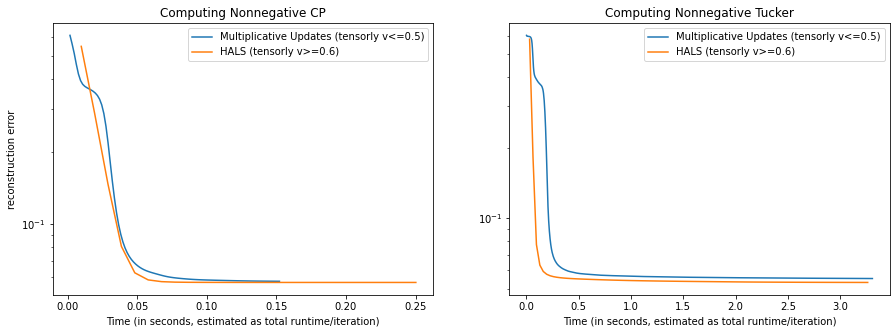

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.semilogy(iter_time_mu,err_cp_mu)
plt.semilogy(iter_time_hals,err_cp_hals)
plt.ylabel('reconstruction error')
plt.legend(['Multiplicative Updates (tensorly v<=0.5)', 'HALS (tensorly v>=0.6)'])
plt.xlabel('Time (in seconds, estimated as total runtime/iteration)')
plt.title('Computing Nonnegative CP')
plt.subplot(122)
plt.semilogy(iter_time_mu_tu,err_tu_mu)
plt.semilogy(iter_time_hals_tu,err_tu_hals)
plt.legend(['Multiplicative Updates (tensorly v<=0.5)', 'HALS (tensorly v>=0.6)'])
plt.xlabel('Time (in seconds, estimated as total runtime/iteration)')
plt.title('Computing Nonnegative Tucker')
plt.show()

Running the experiment several times yields varying improvement margins, but overall the HALS methods run faster, with fewer iterations.

## 2. Constrained CP decomposition with AO-ADMM

Another important addition to Tensorly has been the ability to compute a large class of constrained CP models, using the AO-ADMM algorithm published by Kejun Huang and his collaborators [(paper link)](https://arxiv.org/abs/1506.04209).

Let us use the same toy data, noised, and reconstruct the factors using smoothness inducing Laplacian regularization.

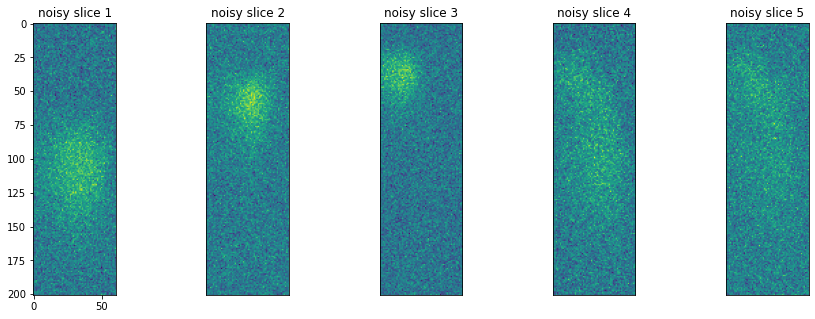

In [6]:
# Adding some Gaussian white noise
X_noisy = X + 300*np.random.randn(5,201,61)
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_noisy[i,:,:])
    plt.title('noisy slice '+str(i+1))
    if i>0:
        plt.xticks([])
        plt.yticks([])

If we fit nonnegative CP without further regularization on X_noisy, we get noised factors.

Text(0.5, 1.0, 'Excitation spectra')

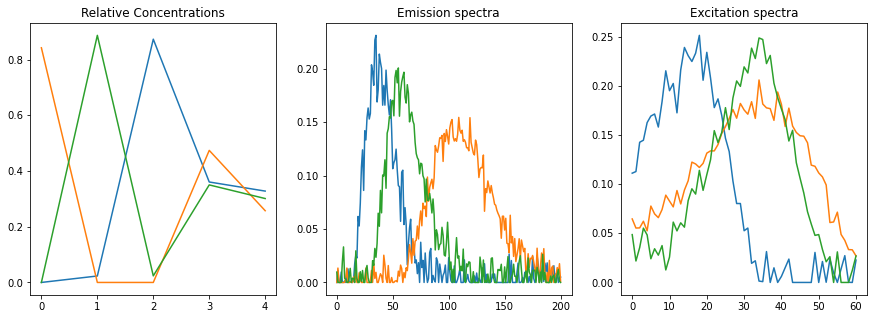

In [7]:
# Computing rank-3 nonnegative CP
noised_cptens = non_negative_parafac_hals(X_noisy,3)
# Post-computation normalization
noised_cptens=tl.cp_tensor.cp_normalize(noised_cptens)
# Plotting the estimated factors
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(noised_cptens[1][0])
plt.title('Relative Concentrations')
plt.subplot(132)
plt.plot(noised_cptens[1][1])
plt.title('Emission spectra')
plt.subplot(133)
plt.plot(noised_cptens[1][2])
plt.title('Excitation spectra')

Using however smoothness regularization, we can make sense again of these estimated factors! Note that it is not yet possible to impose several constraints on each mode, thus we cannot yet impose nonnegativity and smoothness

(note that there are other methods for smooth nonnegative CP such as data pre-processing with hand-crafted splines, here it is just for illustrative purposes)

In [14]:
# Loading the constrained CP decomposition module
from tensorly.decomposition import constrained_parafac

Text(0.5, 1.0, 'Excitation spectra')

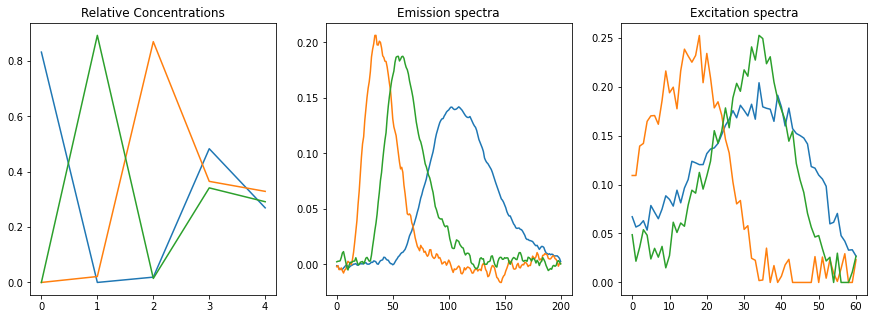

In [15]:
# Simple discoverable API for the constraints.
# Here we regularize mode 2  with smoothness, and modes 1 and 3 with nonnegativity.
denoised_cptens = constrained_parafac(X_noisy,rank=3,smoothness={1:4.5}, non_negative={0:True,2:True})
# Another version with smoothness on two modes, nonnegativity is not ensured
#denoised_cptens = constrained_parafac(X_noisy,rank=3,smoothness={1:4.5,2:4.5}, non_negative={0:True})


# Post-computation normalization
denoised_cptens=tl.cp_tensor.cp_normalize(denoised_cptens)
# Plotting the estimated factors
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(denoised_cptens[1][0])
plt.title('Relative Concentrations')
plt.subplot(132)
plt.plot(denoised_cptens[1][1])
plt.title('Emission spectra')
plt.subplot(133)
plt.plot(denoised_cptens[1][2])
plt.title('Excitation spectra')

The results may vary depending on the initialization, but one may observe that indeed the spectra are effectively denoised in the Emission mode.

There are many other constraints one may impose, such as sparsity, unimodality or sum to one and nonnegativity!

## 3. Other improvements

Some other contributions have been:
- Unify and simplify normalization in decomposition algorithms
- Adding several mid-level functions such as proximal operators, active-set and fista solvers, Khatri-Rao sampler...
- Helping the community build the Class API.
- Correcting various bugs and helping the community with other PRs

## 4. Next big PRs

- We have been working intesively on introducing [Generalized CP](https://arxiv.org/abs/1808.07452) from David Hong and his collaborators, since it is a nice framework allowing to use various losses (not just Euclidien !) almost seemlessly.
- During the whole year, we have collected freely available tensor dataset online, and have begin building some tools to run existing code in tensorly on these data, automatically plotting the results for easy comparison of the available methods. We also want to make sure that a user may compare his own method against existing ones using the benchmark API.